In [18]:
#-*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil
from datetime import datetime
import matplotlib.font_manager as fm
import folium
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)
plt.rcParams['font.sans-serif']=['NanumGothic']
plt.rcParams['axes.unicode_minus']=False

# 포스트 코로나 데이터 시각화 경진대회(DACON)
## 주제
### - 포스트 코로나 시대 유망 품목 및 산업 발굴
### - * 코로나로 인한 국민의 생활/소비의 변화 파악 *

## 목표
### - 포스트 코로나 시대 도움되는 인사이트 발굴
https://dacon.io/competitions/official/235618/data/

# 가설

### 1. 코로나의 영향으로 마스크 등의 위생 관련 물품의 수요 증가로 인해 의학 분야(약국)의 매출이 크게 증가했을 것이다.
### 2. 사회적 거리두기의 영향으로 실내 레저 산업의 매출이 증가했을 것이다.

## load data
#### 매출과 관련 있는 card.csv load

In [19]:
df = pd.read_csv("card_20200717.csv", encoding='utf-8')
df.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000


|  <center>Column</center> |  <center>설명</center> |  <center>합계</center> |
|:--------|:--------|:--------|
|*receipt_dttm* | <center>카드 사용 일자 </center> |2020/01/04 ~ 2020/06/14|
|*adstrd_code* | <center>행정동 코드 </center> ||
|*adstrd_nm* | <center>행정동 명 </center> ||
|*mrhst_induty_cl_code* | <center>가맹점 코드 </center> ||
|*mrhst_induty_cl_nm* | <center>가맹점 명 </center> ||
|*selng_cascnt* | <center>매출 건수 </center> |791,277,267|
|**salamt** | <center>매출 금액 </center> |32,169,402,641,433|
|데이터 개수|3,713,952| ||


## preprocessing

In [20]:
new_df = df.copy()
new_df.isnull().sum(), new_df.isna().sum()

(receipt_dttm            0
 adstrd_code             0
 adstrd_nm               0
 mrhst_induty_cl_code    0
 mrhst_induty_cl_nm      0
 selng_cascnt            0
 salamt                  0
 dtype: int64,
 receipt_dttm            0
 adstrd_code             0
 adstrd_nm               0
 mrhst_induty_cl_code    0
 mrhst_induty_cl_nm      0
 selng_cascnt            0
 salamt                  0
 dtype: int64)

In [21]:
new_df[new_df['selng_cascnt'] < 0].head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
19201,20200106,1141058500,신촌동,9305,학원(회원제형태),-4,452300
21381,20200106,1168051000,신사동,7020,의원,-7,7815000
31270,20200108,1114052000,소공동,4085,PG 상품권,-108,6528781
46347,20200109,1168053100,논현2동,1110,관광여행,-2,2505490
46390,20200109,1168053100,논현2동,9398,기타회원제형태업소4,-2,-504350


매출건수와 매출금액이 마이너스 경우(selng_cascnt: 매출 건수, salamt: 매출액)

-는 취소가 발생한 경우를 의미. 매출 건건이가 일자별 sum이라서 아래의 경우의 수가 발생.
    
    1. selng_cascnt, salamt 모두 음수인 경우
        --> 당일 취소건이 정상건보다 많고,  sum(취소금액) > sum(정상금액)

    2. selng_cascnt는 음수, salamt는 양수인 경우
       --> 당일 취소건이 정상건보다 많고,  sum(취소금액) < sum(정상금액)

    3. selng_cascnt는 양수, salamt는 음수인 경우  
        --> 당일 정상건이 취소건보다 많고,  sum(취소금액) > sum(정상금액)

# 자치구별 매출 시각화

##### (서울시 동 단위 -> 구 단위 변환)

In [22]:
# 행정동명별 매출금액의 합
area_sum = pd.DataFrame(new_df.groupby("adstrd_nm").agg({'salamt': sum}))
area_sum = area_sum.sort_values("salamt", ascending=False)
area_sum["salamt"] =  area_sum["salamt"].apply(lambda x: format(x, ","))

dong = pd.read_csv("seoul_map.csv", sep='\t')
dong = dong.drop(dong[dong['동'] == '소계'].index)
dong = dong.drop([0,1])
dong = dong.set_index('기간')
dong_col = dong[['자치구', '동']]

# 기존 데이터(card.csv)와 외부 데이터(seoul_map.csv - 서울시 자치구 명 데이터) merge
merge_df = pd.merge(df, dong_col, how='inner', left_on='adstrd_nm', right_on='동')
# merge된 데이터에서 필요한 '자치구', '동', '매출 금액' column만 분리
merge_df = merge_df[['자치구', '동',  'salamt']]
# 자치구로 묶고 매출 금액  sum
gu_sum_df = merge_df.groupby('자치구')['salamt'].sum()
# Dataframe으로 변환
sum_df = pd.DataFrame(gu_sum_df)
# 변환 후 매출금액 3자리씩 끊어서 표기
sum_df = sum_df.sort_values(by='salamt', ascending=False)
# sum_df["salamt"] = sum_df["salamt"].apply(lambda x: format(x, ","))
sum_df = pd.DataFrame(gu_sum_df)
# lengend 숫자 겹침 -> sum_df["salamt"]의 단위를 억 단위로 조정
new_sum_df = sum_df.copy()
new_sum_df["salamt"] = new_sum_df["salamt"].apply(lambda x: str(x)[0:5] if len(str(x)) == 13 else str(x)[0:4])
new_sum_df["salamt"] = new_sum_df["salamt"].apply(lambda x: int(x))
new_sum_df = new_sum_df.reset_index()


In [23]:
# read shapefile 
import geopandas as gpd

seoul_file = "./seoul_geo/SIG.shp"
seoul = gpd.read_file(seoul_file, encoding='cp949')
seoul = seoul[0:25]
sum_df = sum_df.reset_index()
# 서울시 위도, 경도 mapping
map_df = pd.read_csv("map_df.csv")
location = map_df[["latitude", "longitude"]].iloc[0].to_list()
m = folium.Map(location, zoom_start=12)

# Choropleth 레이어를 만들고, 맵 m에 추가
folium.Choropleth(geo_data=seoul, data = new_sum_df,
                 columns=('자치구', 'salamt'), key_on='feature.properties.SIG_KOR_NM',
                 fill_color="BuPu", legend_name="sales amount").add_to(m)
m

In [24]:
sum_df = sum_df.sort_values(['salamt'], ascending=False)
sum_df = sum_df.reset_index()
sum_df["salamt"] = sum_df["salamt"].apply(lambda x: format(x, ","))
sum_df[['자치구', 'salamt']].head(6)

,자치구,salamt
0,강남구,"8,547,232,822,404"
1,마포구,"3,482,348,264,686"
2,서초구,"3,479,687,275,182"
3,중구,"3,247,310,004,301"
4,용산구,"2,455,496,379,505"
5,구로구,"1,971,491,561,265"


# 자치구별 유동 인구 수

<BarContainer object of 25 artists>

/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/minsungkim/anaconda3/lib/python3.7/site-packages/matplotlib

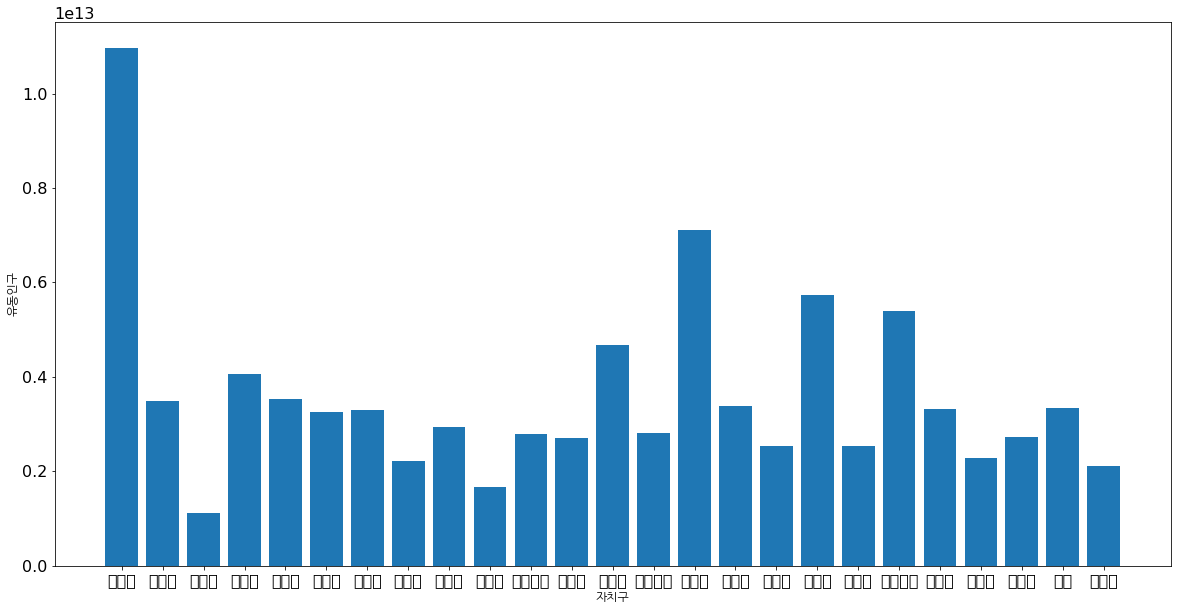

In [25]:
pop_df = pd.read_csv('./fpopl.csv')
pop = pop_df.groupby(['adstrd_code'])['popltn_cascnt'].sum()
new_pop_df = pd.DataFrame(pop)
new_pop_df = new_pop_df.reset_index()
fixed_df = new_df.copy()
fixed_df['adstrd_code'] = fixed_df['adstrd_code'].apply(lambda x: str(x)[0:8])
fixed_df['adstrd_code'] = fixed_df['adstrd_code'].apply(lambda x: int(x))

part_df = fixed_df[['adstrd_code', 'adstrd_nm', 'salamt']]
part_df = part_df.groupby(['adstrd_code'])['salamt'].sum()
part_df = pd.DataFrame(part_df)

total_p_df = pd.merge(part_df, new_pop_df, how='inner', on='adstrd_code')

merge_df = pd.merge(df, dong_col, how='inner', left_on='adstrd_nm', right_on='동')
merge_df = merge_df[['adstrd_code', 'adstrd_nm','자치구', 'salamt']]

merge_df['adstrd_code'] = merge_df['adstrd_code'].apply(lambda x: str(x)[0:8])
merge_df['adstrd_code'] = merge_df['adstrd_code'].apply(lambda x: int(x))
pop_merge_df = pd.merge(merge_df, total_p_df, how='inner', on='adstrd_code')

pop_merge_df = pop_merge_df[['자치구', 'popltn_cascnt']]
pop_merge = pop_merge_df.groupby('자치구')['popltn_cascnt'].sum()
pop_merge_df = pd.DataFrame(pop_merge)
pop_merge_df = pop_merge_df.reset_index()

plt.figure(figsize=(20,10))
plt.xlabel('자치구', fontproperties=fontprop)
plt.ylabel('유동인구', fontproperties=fontprop)
plt.bar(x=pop_merge_df['자치구'], height=pop_merge_df['popltn_cascnt'])

# 매출과 유동인구 상관 관계
### 유동 인구데이터(fpopl.csv)

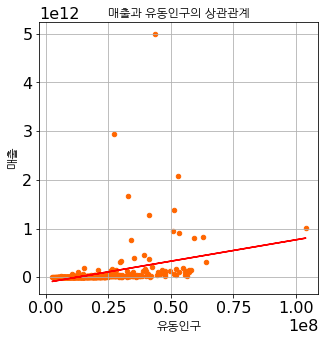

In [30]:
pop_df = pd.read_csv('./fpopl.csv')
pop = pop_df.groupby(['adstrd_code'])['popltn_cascnt'].sum()
new_pop_df = pd.DataFrame(pop)
new_pop_df = new_pop_df.reset_index()
new_pop_df.shape,len(new_pop_df['adstrd_code'].unique())  # adstrd_code는 중복 x

df = pd.read_csv("card_20200717.csv", encoding='utf-8')
new_df = df.copy()
fixed_df = new_df.copy()

fixed_df['adstrd_code'] = fixed_df['adstrd_code'].apply(lambda x: str(x)[0:8])
fixed_df['adstrd_code'] = fixed_df['adstrd_code'].apply(lambda x: int(x))

a_df = fixed_df[['adstrd_code', 'adstrd_nm', 'salamt']]
a_df = a_df.groupby(['adstrd_code'])['salamt'].sum()
a_df = pd.DataFrame(a_df)

total_p_df = pd.merge(a_df, new_pop_df, how='inner', on='adstrd_code')

x =  total_p_df['popltn_cascnt']
y = total_p_df['salamt']

z = np.polyfit(x, y, 1)   # (X,Y,차원) 정의
f = np.poly1d(z)          # 1차원 다
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5, 5)

total_p_df.plot.scatter(x='popltn_cascnt', y='salamt', color='#ff6600', marker='o')
plt.grid()
plt.title("매출과 유동인구의 상관관계", fontproperties=fontprop)
plt.ylabel('매출', fontproperties=fontprop)  
plt.xlabel('유동인구', fontproperties=fontprop) 
plt.plot(x,f(x),'#ff0000')
plt.show()

# 약국, 의료산업 평균 매출 비교

In [27]:
pha_df = new_df.loc[new_df['mrhst_induty_cl_nm']=="약국",:]
pha_df = new_df[['receipt_dttm', 'selng_cascnt', 'salamt']]

pha_df['receipt_dttm'] = pha_df.astype({'receipt_dttm': str})
pha_df['month'] = pha_df['receipt_dttm'].apply(lambda x: x[-4:-2])

new_df['mrhst_induty_cl_code'] = new_df['mrhst_induty_cl_code'].astype(str)

new_df['mrhst_induty_cl_code'] = new_df['mrhst_induty_cl_code'].apply(lambda x: x[0:1])
cat_df = new_df.loc[new_df['mrhst_induty_cl_code'] == '7']

/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [28]:
# 의학
cat_df['mrhst_induty_cl_nm'].unique()

array(['약국', '치과의원', '한의원', '의원', '화 장 품', '미 용 원', '안경', '피부미용실',
       '기타대인서비스', '동물병원', '병원', '안마/스포츠마사지', '의료 용품', '사우나', '미용 재료',
       '종합병원', '이 용 원', '한약방', '기타의료기관및기타의료기기', '치과병원', '산후조리원', '한방병원',
       '제약회사', '건강진단', '조산원'], dtype=object)

/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '월별 평균 의학산업 매출')

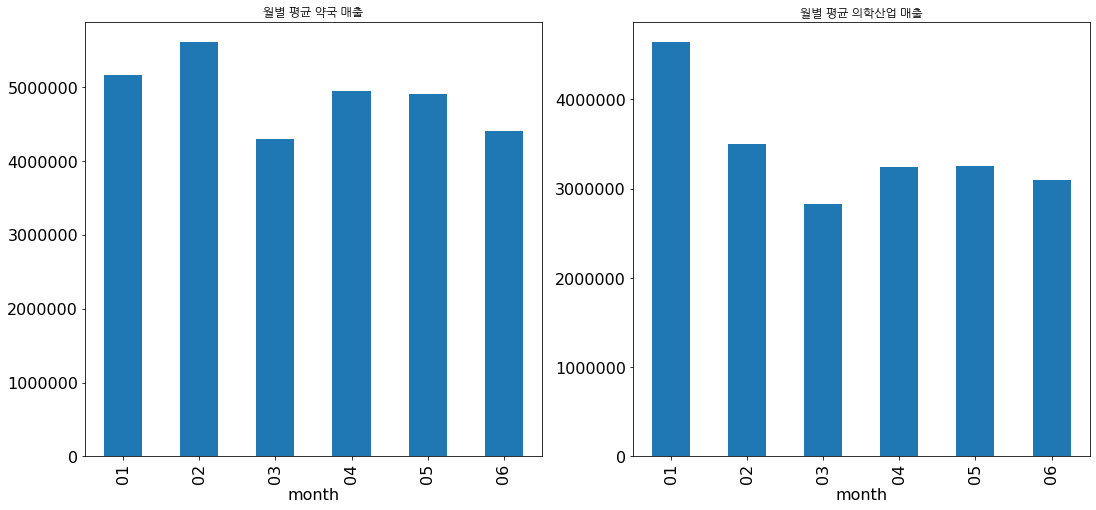

In [29]:
cat_df['month'] = cat_df['receipt_dttm'].astype(str).apply(lambda x: x[-4:-2])

cat_df = cat_df[['receipt_dttm', 'month', 'mrhst_induty_cl_code', 'salamt']]

f, ax=plt.subplots(1,2, figsize=(18,8))

pha_df = pha_df.loc[new_df['mrhst_induty_cl_nm']=="약국",:]

pha_df.groupby(['month'])['salamt'].mean().plot.bar(ax=ax[0])
ax[0].set_title('월별 평균 약국 매출', fontproperties=fontprop)

cat_df.groupby(['month'])['salamt'].mean().plot.bar(ax=ax[1])
ax[1].set_title('월별 평균 의학산업 매출', fontproperties=fontprop)

# 약국 매출

/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


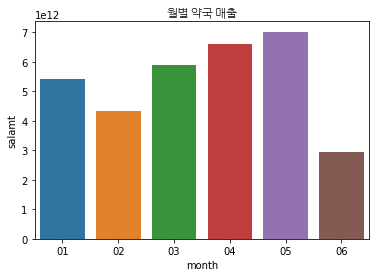

In [65]:
df = pd.read_csv("card_20200717.csv", encoding='utf-8')
df.head()
new_df = df.copy()
pha_df = new_df.loc[new_df['mrhst_induty_cl_nm']=="약국",:]
pha_df = new_df[['receipt_dttm', 'selng_cascnt', 'salamt']]

pha_df['receipt_dttm'] = pha_df.astype({'receipt_dttm': str})
pha_df['month'] = pha_df['receipt_dttm'].apply(lambda x: x[-4:-2])
pha_df.head()

# countplot(x="column_name", data=dataframe)
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

mon_sal = pha_df.groupby(['month'])['salamt'].sum()
mon_sal_df = pd.DataFrame(mon_sal, columns=['month', 'salamt'])

del mon_sal_df['month']

mon_sal_df = mon_sal_df.reset_index()

sns.barplot(x='month', y='salamt', data=mon_sal_df)
plt.title("월별 약국 매출", fontproperties=fontprop)
plt.show()

#### 2월 마스크 사재기 수급안정조치 이후 약국 매출 감소, 3월 마스크 5부제 실시 이후 다시 증가

## 이동평균

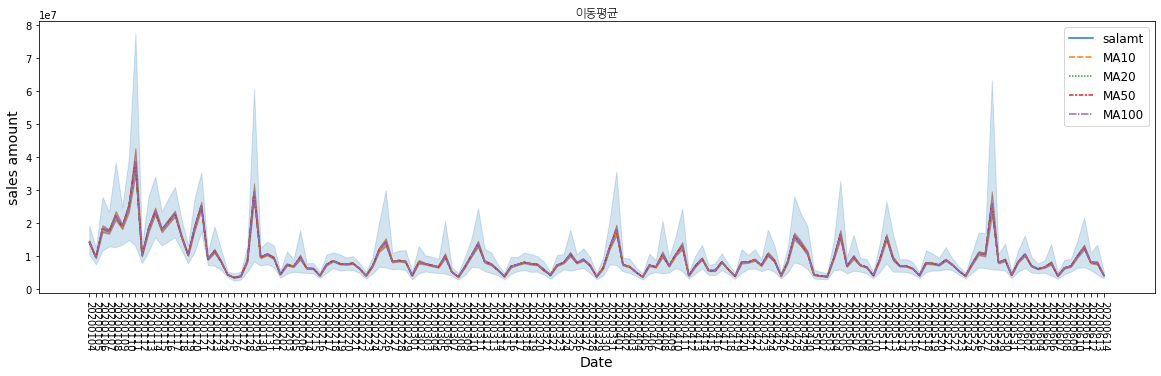

In [66]:
del pha_df['month']


ma10 = pha_df['salamt'].rolling(window=10).mean()
ma20 = pha_df['salamt'].rolling(window=20).mean()
ma50 = pha_df['salamt'].rolling(window=50).mean()
ma100 = pha_df['salamt'].rolling(window=100).mean()


pha_df.insert(len(pha_df.columns), "MA10", ma100)  # 10일 단위
pha_df.insert(len(pha_df.columns), "MA20", ma100)  # 20일 단위
pha_df.insert(len(pha_df.columns), "MA50", ma100)  # 50일 단위
pha_df.insert(len(pha_df.columns), "MA100", ma100)  # 100일 단위

pha_df = pha_df.set_index('receipt_dttm')
del pha_df['selng_cascnt']

plt.figure(figsize=(20, 5))
plt.xticks(rotation=-90)
ax = sns.lineplot(data=pha_df)
plt.title("이동평균", fontsize=12, fontproperties=fontprop)
plt.ylabel('sales amount', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

### 20200104 ~ 20200614 까지 6개월 데이터 단순 이동 평균 이동평균선의 흐름이 비슷

## 사회적 거리두기의 영향으로 실외 활동을 대신해 실내 레저 산업의 매출이 증가했을 것이다.

### 노래방 집합 금지령으로 실제 노래방의 매출이 감소했을까?

In [15]:
song_df=new_df.loc[new_df['mrhst_induty_cl_nm']=="노래방",:]
song_df['receipt_dttm'] = song_df['receipt_dttm'].apply(str)
song_df['receipt_dttm'] = song_df['receipt_dttm'].apply(pd.to_datetime)

/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 시간에 따른 노래방 매출 추이

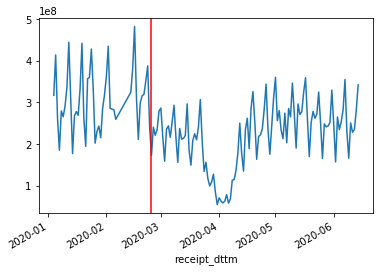

In [69]:
song_df.groupby('receipt_dttm')['salamt'].sum().plot()
plt.axvline('2020-02-25', color='r')

In [70]:
# 2월 말 코인 노래방 최초 감염자 사례 이후 감소
# https://moneys.mt.co.kr/news/mwView.php?no=2020022513278027875

### 코로나의 영향으로 생명 보험의 매출은 증가했을까?

/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/minsungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

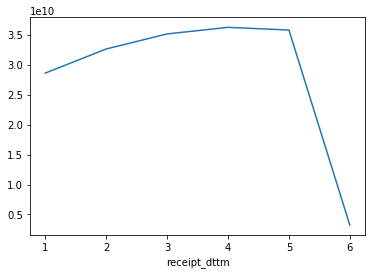

In [17]:
insurance_df=new_df.loc[new_df['mrhst_induty_cl_nm']=="생명 보험",:]
insurance_df['receipt_dttm'] = insurance_df['receipt_dttm'].apply(str)
insurance_df['receipt_dttm'] = insurance_df['receipt_dttm'].apply(pd.to_datetime)
insurance_df['receipt_dttm'] = insurance_df['receipt_dttm'].dt.month
insurance_df.groupby('receipt_dttm')['salamt'].sum().plot()

In [72]:
insurance_df.shape, insurance_df.groupby('receipt_dttm')['salamt'].count(), insurance_df.groupby('receipt_dttm')['salamt'].sum()

((857, 7),
 receipt_dttm
 1     58
 2    132
 3    195
 4    190
 5    194
 6     88
 Name: salamt, dtype: int64,
 receipt_dttm
 1    28606997976
 2    32629950625
 3    35135425183
 4    36235997069
 5    35787800666
 6     3238776596
 Name: salamt, dtype: int64)

In [19]:
leisure_df=new_df.loc[new_df['mrhst_induty_cl_code']=="2",:]
leisure_df['mrhst_induty_cl_nm'].unique()

/home/minsungkim/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([], dtype=object)

In [73]:
# 노래방, 당구장, 헬스 클럽, 영화관, 스크린골프, 볼링장, 수영장
df1 = new_df.loc[new_df['mrhst_induty_cl_nm']=="노래방",:]
df2 = new_df.loc[new_df['mrhst_induty_cl_nm']=="당구장",:]
df3 = new_df.loc[new_df['mrhst_induty_cl_nm']=="헬스 크럽",:]
df4 = new_df.loc[new_df['mrhst_induty_cl_nm']=="영화관",:]
df5 = new_df.loc[new_df['mrhst_induty_cl_nm']=="스크린골프",:]
df6 = new_df.loc[new_df['mrhst_induty_cl_nm']=="볼 링 장",:]
df7 = new_df.loc[new_df['mrhst_induty_cl_nm']=="수 영 장",:]

leisure_df = pd.concat([df1,df2,df3,df4,df5,df6,df7], ignore_index=True)
leisure_df['month'] = leisure_df['receipt_dttm'].astype(str).apply(lambda x: x[-4:-2])
leisure_df = leisure_df[['month', 'mrhst_induty_cl_nm', 'salamt']]

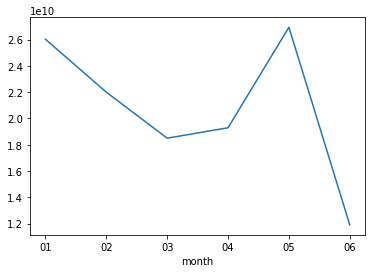

In [75]:
leisure_df.groupby('month')['salamt'].sum().plot()

In [92]:
leisure_df.groupby(['month'])[['mrhst_induty_cl_nm', 'salamt']].sum()

,salamt
month,
01,26025103484
02,21996359376
03,18494160177
04,19285824918
05,26936719161
06,11892687178


In [114]:
leisure_df=new_df.loc[new_df['mrhst_induty_cl_code']=="2",:]
leisure_df = pd.concat([df1,df2,df3,df4,df5,df6,df7], ignore_index=True)
leisure_df = leisure_df[['receipt_dttm', 'selng_cascnt', 'salamt']]
leisure_df

/home/minsungkim/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,receipt_dttm,selng_cascnt,salamt
0,20200104,21,1758000
1,20200104,18,632000
2,20200104,21,709000
3,20200104,21,819000
4,20200104,23,1705000
...,...,...,...
180352,20200614,1,1100000
180353,20200614,1,144000
180354,20200614,1,120000
180355,20200614,1,361000


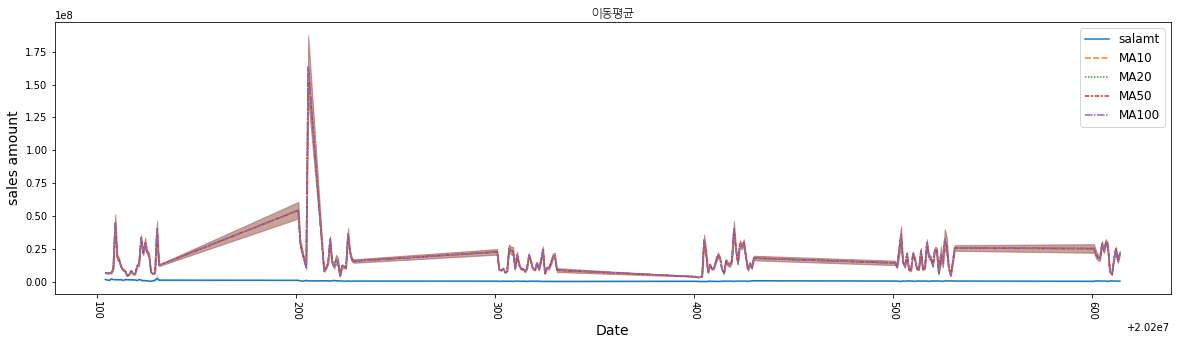

In [115]:
leisure_df.insert(len(leisure_df.columns), "MA10", ma100)  # 10일 단위
leisure_df.insert(len(leisure_df.columns), "MA20", ma100)  # 20일 단위
leisure_df.insert(len(leisure_df.columns), "MA50", ma100)  # 50일 단위
leisure_df.insert(len(leisure_df.columns), "MA100", ma100)  # 100일 단위

leisure_df = leisure_df.set_index('receipt_dttm')
del leisure_df['selng_cascnt']

plt.figure(figsize=(20, 5))
plt.xticks(rotation=-90)
ax = sns.lineplot(data=leisure_df)
plt.title("이동평균", fontsize=12, fontproperties=fontprop)
plt.ylabel('sales amount', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()